<h3>Fraud Detection using Random Forest</h3>
<p>Kaggle Credit Card Fraud Data Set - https://www.kaggle.com/mlg-ulb/creditcardfraud - 
<br>sklearn, RandomForest</p>

In [6]:
import sys, os, time, gc

import pandas as pd
import numpy as np

from collections import Counter
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score,       \
                            recall_score,          \
                            f1_score,              \
                            fbeta_score,           \
                            confusion_matrix,      \
                            auc,                   \
                            precision_recall_curve 
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE,  ADASYN

In [7]:
input_file = 'data/creditcard.csv'
df = pd.read_csv(input_file)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


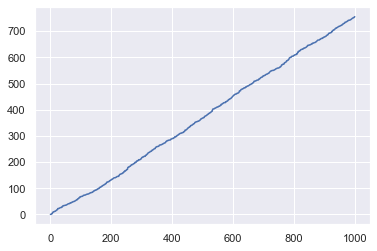

In [8]:
plt.plot(df.Time.iloc[:1000]);

### Checking the target classes

In [9]:
Counter(df.Class)

Counter({0: 284315, 1: 492})

### Rescale Amount, add columns for minutes and hours

In [10]:
# make a column 'A' - and put there value of 'Amount' rescaled into (-1,1)
sc = StandardScaler()
df['A']= sc.fit_transform(df.Amount.values.reshape(-1, 1))

# add columns for minuts and hours
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_min'] = (timedelta.dt.components.minutes).astype(int)
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,A,Time_min,Time_hour
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727,2.913952e-17,28.997044,14.046470
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,1.000002e+00,17.427849,5.835854
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,-3.532294e-01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,-3.308401e-01,14.000000,10.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000,-2.652715e-01,29.000000,15.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000,-4.471707e-02,44.000000,19.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000,1.023622e+02,59.000000,23.000000


### Correlations of Numerical Variables

In [12]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'A', 'Time_min', 'Time_hour'], dtype='object')

In [13]:
cols = []
for ii in range(1,29):
    cols += ["V%d"%ii]
cols += ['A'] + ['Time_min'] + ['Time_hour']
print(str(cols))
# ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 
# 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 
# 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 
# 'A', 'Time_min', 'Time_hour']

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'A', 'Time_min', 'Time_hour']


In [14]:
# find which columns' values change their distribution the most
# when we change from rows with Class=0 to Class==1.
# To compare two distributions we will use Kolmogorov-Smirnov test.
#  - https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
# Note - this is just one of many tests, for example, read this discussion:
#  - https://stats.stackexchange.com/questions/1001/is-spearmans-correlation-coefficient-usable-to-compare-distributions
# 
# function ks_2samp(array1, array2) 
# compares distributions of values in two arrays
# and returns p_value
#    p_value > 0.4 - distributions are very similar (identical)
#    p_value very small - distributions differ

ks = []
print("small p_values indicate different distributions")
print('-'*40)
print("label => p_value") 
print('-'*40)
for col in cols:
    vals_0 = df[df.Class == 0][col].values # values for column <col> for rows where Class==0
    vals_1 = df[df.Class == 1][col].values # values for column <col> for rows where Class==1
    p_val = ks_2samp(vals_0, vals_1)[1]    # p_val is bigger for similar distributions
    ks.append((col, p_val))
    print("%s => %.6f" % (col,p_val))

small p_values indicate different distributions
----------------------------------------
label => p_value
----------------------------------------
V1 => 0.000000
V2 => 0.000000
V3 => 0.000000
V4 => 0.000000
V5 => 0.000000
V6 => 0.000000
V7 => 0.000000
V8 => 0.000000
V9 => 0.000000
V10 => 0.000000
V11 => 0.000000
V12 => 0.000000
V13 => 0.000053
V14 => 0.000000
V15 => 0.036886
V16 => 0.000000
V17 => 0.000000
V18 => 0.000000
V19 => 0.000000
V20 => 0.000000
V21 => 0.000000
V22 => 0.071807
V23 => 0.000000
V24 => 0.000000
V25 => 0.000910
V26 => 0.000570
V27 => 0.000000
V28 => 0.000000
A => 0.000000
Time_min => 0.646457
Time_hour => 0.000000


In [15]:
# pick 10 most correlated variables.
# create DataFrame [label, p_val]
ks_df = pd.DataFrame(data = ks, columns = ['label', 'p_val'])
# sort by p_val in decreasing order
sorted_by_pvals = ks_df.sort_values(by='p_val',ascending=False)[:10] # .label.iloc[:20]
sorted_by_pvals

,label,p_val
29,Time_min,6.464573e-01
21,V22,7.180676e-02
14,V15,3.688624e-02
24,V25,9.097462e-04
25,V26,5.702418e-04
12,V13,5.338334e-05
23,V24,1.323582e-07
22,V23,1.074846e-14
30,Time_hour,1.383461e-16
28,A,2.170305e-32


<h3>Create Cross-Validation Folds</h3>
<p>We randomly split all data rows in 4 groups (folds) numbered as 0,1,2,3
<br>For modeling we will randomly select one of the folds as test data, 
<br>and combination of other three folds as training data.
<br>Thus we can repeat modeling 4 times (if there are 4 folds).
<br>Below we do that. We also repeat everything 3 times.
<br>So we make 12 calculations, and then calculate mean and standard deviation.</p>

In [16]:
n_cv = 4           # number of cross-validation folds
df_len = len(df)   # length of data

# randomly populate column cv_fold with numbers 0,1,2,3
df['cv_fold'] = np.random.randint(0,4, df_len)  
print("values in column 'cv_fold':", np.unique(df['cv_fold']))

print("check that classes (0 or 1) are approx evenly distributed")
print("between folds: (0+1+2+3)/4 = 1.5")
print ("0 => %.4f" % np.mean(df.cv_fold[df.Class == 0]))
print ("1 => %.4f" % np.mean(df.cv_fold[df.Class == 1]))

values in column 'cv_fold': [0 1 2 3]
check that classes (0 or 1) are approx evenly distributed
between folds: (0+1+2+3)/4 = 1.5
0 => 1.4961
1 => 1.5752


<h3>run_cv() - Random Forest without imputing data</h3>

In [17]:
def run_cv(model, label, columns, repeat = 1):
    """
    #  runs RandomForestClassifier
    #  gets data from external DataFrame df:
    #      X => df[columns]
    #      Y => df['Class']
    #  goess through n_cv folds
    #  repeats "repeat" times
    #  (12 calculations, if n_cv=4, and repeat=3)
    #  returns dictionary "res" 
    #      keys   [precision, recall, f1core]
    #      values as tuples (mean, std_deviation)
    """   
    print("running ", label)
    t1=time.time()
    precisions = []
    recalls = []
    f1scores = []
    n_cv = len(df.cv_fold.unique())

    for cycle in range(repeat):
        # ----------------------------
        for n in range(n_cv):
            print("(rep=%d, fold=%d), " % (cycle,n), end='')
            X_train = df[df.cv_fold != n][columns]
            Y_train = df[df.cv_fold != n]['Class']
            X_test = df[df.cv_fold == n][columns]
            Y_test = df[df.cv_fold == n]['Class']
            model.fit(X_train, Y_train)

            Y_predict = model.predict(X_test)
            recalls.append    (recall_score   (Y_test, Y_predict))
            precisions.append (precision_score(Y_test, Y_predict))
            f1scores.append   (f1_score       (Y_test, Y_predict))
        print()
        # ----------------------------

    res = {}
    res['precision'] = (np.mean(precisions), np.std(precisions))
    res['recall'] = (np.mean(recalls), np.std(recalls))
    res['f1score'] = (np.mean(f1scores),np.std(f1scores))

    print("\nfinished %d calculations" % (repeat*n_cv))
    print ("Precision : %.6f +- %.6f" % (np.mean(precisions) , np.std(precisions)))
    print ("Recall    : %.6f +- %.6f" % (np.mean(recalls)    , np.std(recalls)))
    print ("F1 score  : %.6f +- %.6f" % (np.mean(f1scores)   , np.std(f1scores)))
    print("Elapsed %.2f sec" % (time.time()-t1) )
    print('-'*65,"\n")
    return res

<h3>run_cv_smote() - Random Forest with imputing data</h3>

In [18]:
def run_cv_smote(model, label, columns, resampler, repeat = 1):
    """
    #  runs RandomForestClassifier
    #  with imputing values into minority class
    #  (using SMOTE or ADASYN to decrease imbalance between classes)
    #  gets data from external DataFrame df:
    #      X => df[columns]
    #      Y => df['Class']
    #  goess through n_cv folds
    #  repeats "repeat" times
    #  (12 calculations, if n_cv=4, and repeat=3)
    #  returns dictionary "res" 
    #      keys   [precision, recall, f1core]
    #      values as tuples (mean, std_deviation)
    """    
    print("running ", label)
    t1=time.time()
    precisions = []
    recalls = []
    f1scores = []
    n_cv = len(df.cv_fold.unique())
    for cycle in range(repeat):
        # ----------------------------
        for n in range(n_cv):
            print("(rep=%d, fold=%d), " % (cycle,n), end='')
            X_train = df[df.cv_fold != n][columns]
            Y_train = df[df.cv_fold != n]['Class']
            X_test = df[df.cv_fold == n][columns]
            Y_test = df[df.cv_fold == n]['Class']
            #sm = SMOTE(random_state=12,  k_neighbors=5, ratio = {1:sum(Y_train == 0)})
            x_train_res, y_train_res = resampler.fit_sample(X_train, Y_train)
            model.fit(x_train_res, y_train_res)

            Y_predict = model.predict(X_test)
            recalls.append(recall_score(Y_test, Y_predict))
            precisions.append(precision_score(Y_test, Y_predict))
            f1scores.append(f1_score(Y_test, Y_predict))
        print()
        # ----------------------------
    res = {}
    res['precision'] = (np.mean(precisions), np.std(precisions))
    res['recall'] = (np.mean(recalls), np.std(recalls))
    res['f1score'] = (np.mean(f1scores),np.std(f1scores))

    print("\nfinished %d calculations" % (repeat*n_cv) )
    print ("Precision : %.6f +- %.6f" % (np.mean(precisions) , np.std(precisions)))
    print ("Recall    : %.6f +- %.6f" % (np.mean(recalls)    , np.std(recalls)))
    print ("F1 score  : %.6f +- %.6f" % (np.mean(f1scores)   , np.std(f1scores)))
    print("Elapsed %.2f sec" % (time.time()-t1))
    print('-'*65,"\n")
    return res

In [19]:
# dict for results
results = {}

<h3>Functions to run different cases</h3>

In [20]:
# --------------------------------------------------------------
def run_baseline():
    rfc = RandomForestClassifier()
    results['baseline'] = run_cv(rfc, 'baseline', cols, repeat = 3)

# --------------------------------------------------------------
def run_with_class_weights():
    rfc = RandomForestClassifier(class_weight="balanced")
    results['balanced_class_weight'] = run_cv(rfc, 'balanced weights', cols, repeat = 3)

# Use SMOTE and ADASYN Oversampling techniques for minority class
#   SMOTE = Synthetic Minority Over sampling Technique 
#   ADASYN = ADAptive SYNthetic 
# Both algorithms use KNN (K Nearest Neighbors) 
# The key difference between ADASYN and SMOTE is that 
#   - SMOTE generates the same number of synthetic samples 
#     for each original minority sample.
#   - ADASYN uses a density distribution, as a criterion 
#   to automatically decide the number of synthetic samples 
#   that must be generated for each minority sample 
#   by adaptively changing the weights of the different minority 
#   samples to compensate for the skewed distributions.

# --------------------------------------------------------------
def run_smote_1():
    rfc = RandomForestClassifier()
    sm = SMOTE(random_state = 12, ratio = 'minority')
    results['smote'] = run_cv_smote(rfc, 'SMOTE minority', cols, sm, repeat = 3)

# --------------------------------------------------------------
def run_smote_2():
    rfc = RandomForestClassifier()
    sm = SMOTE(random_state = 12, ratio = 'minority', kind = 'borderline1')
    results['smote_borderline1'] = run_cv_smote(rfc, 'SMOTE minority borderline1', cols, sm, repeat = 3)

# --------------------------------------------------------------
def run_adasyn():
    rfc = RandomForestClassifier()
    ada = ADASYN(random_state=42, ratio = 'minority')
    results['adasyn'] = run_cv_smote(rfc, 'ADASYN minority', cols, ada, repeat = 3)

<h3>Now we can run all cases as needed</h3>

In [21]:
run_baseline()
run_with_class_weights()
run_smote_1()
run_smote_2()
run_adasyn()

running  baseline
(rep=0, fold=0), (rep=0, fold=1), 

KeyboardInterrupt: 

<h3>Prepare Summary Table of All Results</h3>

In [ ]:
results_orig = results.copy()

In [ ]:
# round the results to 3 decimals
for k1 in results.keys():
    for k2 in results[k1].keys():
        (v1,v2) = results[k1][k2]
        v1 = round(v1,3)
        v2 = round(v2,3)
        results[k1][k2] = (v1,v2)

In [ ]:
df_result = pd.DataFrame.from_dict(results)

In [ ]:
# print results as tuples (value, std), where std = Standard Deviation
# for example (0.5, 0.1) means: 0.5 +/- 0.1
df_result.transpose()

<p>Note that "smote" has the highest recall (0.817).
<br>This means that it captures more real fraud events than other methods. 
<br>At a cost of also identifying more good transactions as Fraud.</p>